### **Project Management Prognostic Risk Scoring Model for Web App**

*Data Science & Learning Systems*

Overview

Risk scoring models ingest user data generated from online project management app to alert project managers of the potential risk of project non delivery by teams and team members. This provides project managers an early warning of sources of project risk so they can intervene to reduce those risks.

Data

Data elements include user interactions on app including team and group posts, likes, dislikes of user and team posts to predict probability of assigned/commited task completion below 50% on a given week. 

Data Generating Process

*   Sprints every 2 weeks
*   Sprints defined by team and tenant
*   Team member activities aggregated by week to reduce effect of users retroactively entering task completions in the system
*   Define success as 50% of tasks committed to completed

ML pipelines

1.   Create training and test samples for CV
2.   Transformations on training and test separately
3.   Algorithm spot check
4.   Eval
5.   Predict
6.   Hyper parameter tuning of best models

### **Data Inspection, Cleaning and Transformation**

--------------------------------------------------------------------------
Check for missing values:
 date             0.000000
userID           0.000000
userName         0.000000
teamName         0.000000
teamID           0.000000
tenantName       0.868456
tenantID         0.000000
teamPost         0.000000
homePost         0.000000
groupPost        0.000000
like             0.000000
dislike          0.000000
comment          0.000000
personalReply    0.000000
share            0.000000
taskCreate       0.000000
taskAssign       0.000000
taskAccept       0.000000
taskCommit       0.000000
worklog          0.000000
taskComment      0.000000
taskComplete     0.000000
dtype: float64
Check for missing values: None
--------------------------------------------------------------------------
Team name to id dictionary: {'Service Desk': 62, 'Devteam': 75, 'HR': 68, 'Sales Team': 81}
--------------------------------------------------------------------------
User id to team name dictionary: {18: 

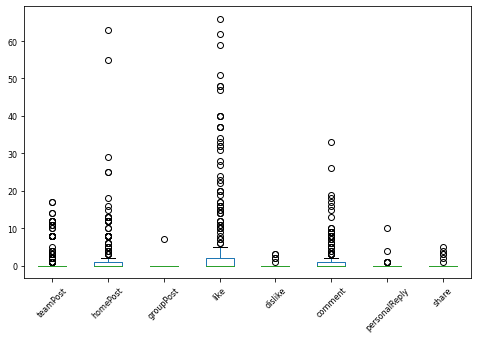

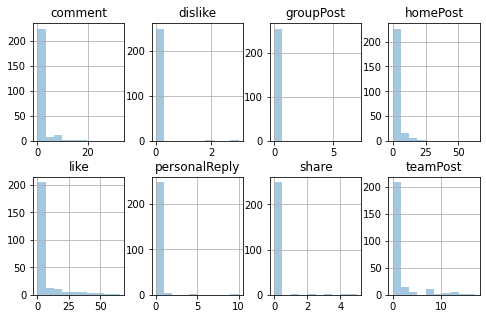

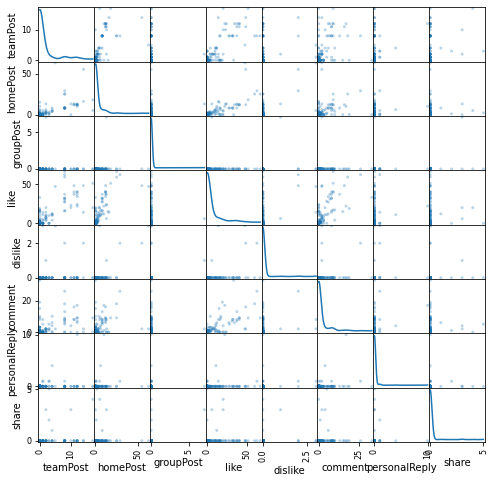

--------------------------------------------------------------------------
Team Activity Distributions


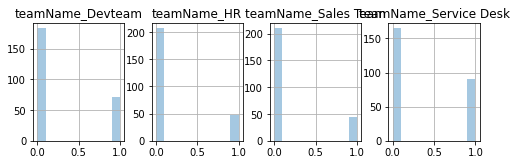

In [0]:
# import libs
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
np.set_printoptions(precision=2)
from datetime import datetime as dt
import matplotlib.pyplot as plt
plt.close('all')
from pandas.plotting import scatter_matrix
from sklearn import preprocessing

# check for missing values
def ck4miss(df):
  """check for missing values in dataframes"""
  miss = df.isnull().sum() / len(df)
  print('Check for missing values:\n', miss)
  #return miss

# file paths 
file1 = '/content/data_baseline.csv'
file2 = '/content/data_batch.csv'

if __name__ == '__main__':
  """1. Read datasets and concat, 2. format date, check types and distributions,
  3. sort by tenant-team-user, 4. set index to date, 5. groupby tenant-team-user + 
  resample().sum() activities by week starting Tues, 6. QC with descriptives + plots.""" 

  # 1st dataset - removed samples with all zeros by teamName
  data = pd.read_csv(file1, sep=',')
  # 2nd dataset 10/30/19 - checked 1.30.2020
  data2 = pd.read_csv(file2, sep=',')
  # concat 2nd dataset to 1st dataset along rows, i.e. stack
  data_update = pd.concat([data, data2], axis=0)
  # specify datetime format and set index 
  data_update['date'] = pd.to_datetime(data_update['date'], format='%m/%d/%Y')
  # filter by teamName per client instructions
  tname_filter = ['Service Desk','Sales Team','dataDev','HR','Devteam']
  # after using filter, reset index to remove warning 'slice vs copy'
  data_filter = data_update.loc[data_update['teamName'].isin(tname_filter)].reset_index(drop=True)
  # check for missing values
  print('-'*74)
  print(f'Check for missing values: {ck4miss(data_update)}')
  # create dict of team name to team ids and map to new column
  team_dict = dict(zip(data_filter.teamName,data_filter.teamID))
  print('-'*74)
  print(f'Team name to id dictionary: {team_dict}')
  uIDtName_dict = dict(zip(data_filter.userID, data_filter.teamName)) 
  print('-'*74)
  print(f'User id to team name dictionary: {uIDtName_dict}')
  data_filter['teamName'] = data_filter['userID'].map(uIDtName_dict)
  tn_cnts = data_filter['teamName'].value_counts()
  print('-'*74)
  print(f'Team name counts:\n {tn_cnts}')
  
  
  """ 1. sort by ids (inplace) + date 2. set datetime index inplace + drop 
  3. groupby (only ids - no date) + resample""" 

  # sort + groupby + feature lists
  sort_list = ['teamName','userID','date']
  gb_list = ['teamName','userID']
  f_items = ['teamPost','homePost','groupPost','like','dislike','comment','personalReply','share',
             'taskCreate','taskAssign','taskAccept','taskCommit','worklog','taskComment','taskComplete']
  a_items = ['teamPost','homePost','groupPost','like','dislike','comment','personalReply','share']
  t_items = ['taskCommit','taskComplete']
  
  # 1. sort data using groupby list first 
  data_filter.sort_values(by=sort_list,inplace=True)
  
  # 2. set datetime index for resample
  data_filter.set_index(pd.DatetimeIndex(data_filter['date']), inplace=True,drop=True)
  
  # 3. groupby & resample to sum week begining Tue
  data_gb_rs = data_filter.groupby(gb_list).resample('W-Tue') [f_items].sum()
  
  # 4. create performance score
  data_gb_rs['pscore'] =  0.5*data_gb_rs['taskComplete'] - data_gb_rs['taskCommit']
  s_items = ['pscore']
  
  # 5. create performance categories from score
  data_gb_rs['pcat'] = np.where(data_gb_rs['pscore'] >= 0,'good','bad')
  data_gb_rs['pcat_num'] = np.where(data_gb_rs['pscore'] >= 0,0,1).astype('int32')
  ideal_cat_cnt = data_gb_rs['pcat'].value_counts(normalize=False).sort_index()
  ideal_cat_per = data_gb_rs['pcat'].value_counts(normalize=True).sort_index()
  print('-'*74)
  print(f'Performance Class Distribution:\n {ideal_cat_cnt},\n {ideal_cat_per}')
  
  # 6. check correlations within and between features and score
  t_corr = data_gb_rs.corr()
  print('-'*74)
  print('Correlation of Performance Score with Model Features')
  print('  (Negative correlations indicate predictor of good performance)')
  print(t_corr['pscore'].sort_values())
  data_gb_rs.reset_index(inplace=True)

  # 7. one hot encode teamName & userName effects using pandas get_dummies()
  data_gb_rs.reset_index(inplace=True)
  cat_cols = ['teamName']
  data_gb_rs_1h = pd.get_dummies(data_gb_rs, prefix_sep="_", columns=cat_cols)
  
  # 8. generate list of team features
  t1h_list = list(data_gb_rs_1h.filter(like='teamName_'))

  # 9. create dict of user name to team ids/names and map to new column
  print('-'*74)
  print('Data QC: after aggregation & team 1 hot encoding')
  print(data_gb_rs_1h.describe().T)
  
  # 10. plot hist by performance category
  tID = ['teamName_Devteam', 'teamName_HR', 'teamName_Sales Team', 'teamName_Service Desk']  
  
  # 11. plot distributions
  print('-'*74)
  print('User Activity Distributions')
  data_gb_rs_1h[a_items].plot.box(fontsize=8, figsize=(8,5), rot=45)
  data_gb_rs_1h[a_items].hist(alpha=0.4, figsize=(8,5), layout=(2,4))
  scatter_matrix(data_gb_rs_1h[a_items], alpha=0.3, figsize=(8,8), diagonal='kde')
  plt.show()
  
  print('-'*74)
  print('Team Activity Distributions')
  data_gb_rs_1h[tID].hist(alpha=0.4, figsize=(8,5), layout=(2,4))
  plt.show()



## **ML Pipeline**

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


--------------------------------------------------------------------------
Features
                       count      mean        std  min  25%  50%  75%   max
teamPost               255.0  1.364706   3.333841  0.0  0.0  0.0  0.0  17.0
homePost               255.0  2.235294   6.665779  0.0  0.0  0.0  1.0  63.0
groupPost              255.0  0.027451   0.438357  0.0  0.0  0.0  0.0   7.0
like                   255.0  5.290196  12.033504  0.0  0.0  0.0  2.0  66.0
dislike                255.0  0.043137   0.323158  0.0  0.0  0.0  0.0   3.0
comment                255.0  1.505882   4.078820  0.0  0.0  0.0  1.0  33.0
personalReply          255.0  0.074510   0.686152  0.0  0.0  0.0  0.0  10.0
share                  255.0  0.070588   0.496957  0.0  0.0  0.0  0.0   5.0
taskComment            255.0  4.188235   8.232107  0.0  0.0  0.0  6.0  56.0
teamName_Devteam       255.0  0.282353   0.451029  0.0  0.0  0.0  1.0   1.0
teamName_HR            255.0  0.188235   0.391669  0.0  0.0  0.0  0.0   1.0
team

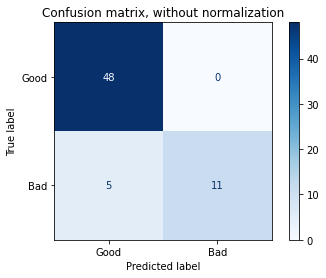

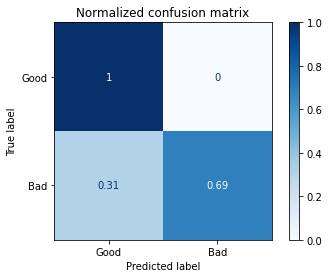

--------------------------------------------------------------------------
AdaBoostClassifier score: 0.828125
Confusion matrix, without normalization
[[41  7]
 [ 4 12]]
Normalized confusion matrix
[[0.85 0.15]
 [0.25 0.75]]


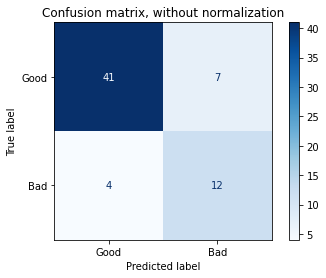

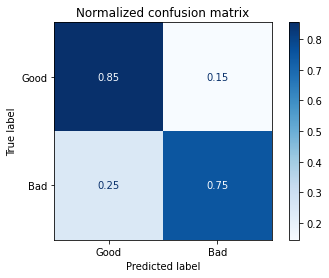

--------------------------------------------------------------------------
BaggingClassifier score: 0.890625
Confusion matrix, without normalization
[[43  5]
 [ 2 14]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.12 0.88]]


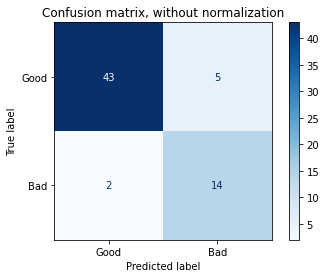

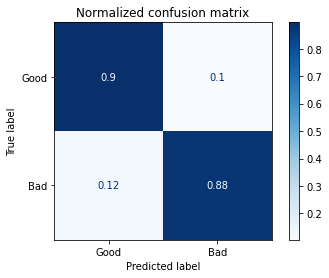

--------------------------------------------------------------------------
RandomForestClassifier score: 0.906250
Confusion matrix, without normalization
[[44  4]
 [ 2 14]]
Normalized confusion matrix
[[0.92 0.08]
 [0.12 0.88]]


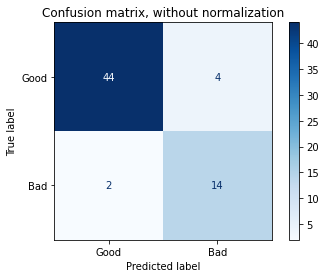

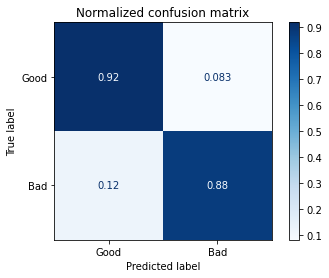

--------------------------------------------------------------------------
ExtraTreesClassifier score: 0.890625
Confusion matrix, without normalization
[[44  4]
 [ 3 13]]
Normalized confusion matrix
[[0.92 0.08]
 [0.19 0.81]]


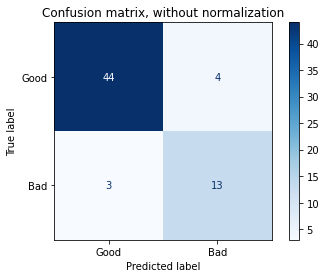

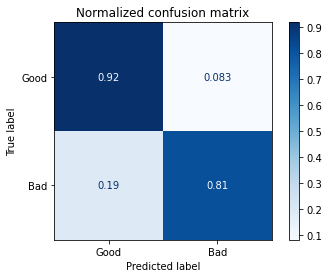

--------------------------------------------------------------------------
GradientBoostingClassifier score: 0.890625
Confusion matrix, without normalization
[[43  5]
 [ 2 14]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.12 0.88]]


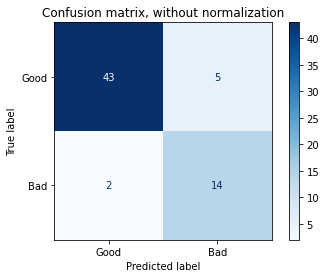

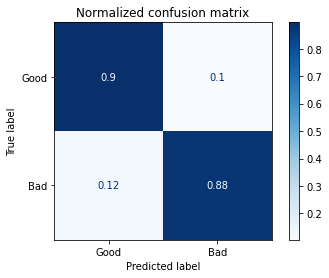

--------------------------------------------------------------------------
GradientBoostingClassifier score: 0.890625
Confusion matrix, without normalization
[[43  5]
 [ 2 14]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.12 0.88]]


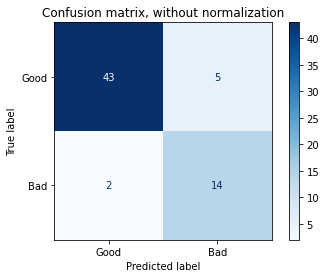

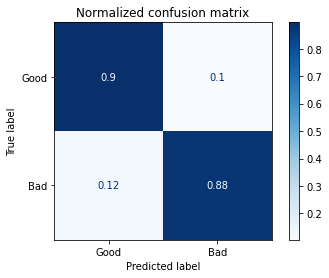

Random Forest Classifier
Test Data: Predicted Class and Class Probabilities
{1: array([0.22, 0.78]), 0: array([1., 0.])}
Permutation Importance for Train Data
{'teamPost': 0.00890052356020945, 'homePost': 0.04764397905759169, 'groupPost': 0.0, 'like': 0.03350785340314143, 'dislike': 0.0, 'comment': 0.02513089005235607, 'personalReply': 0.0, 'share': 0.0, 'taskComment': 0.3240837696335079, 'teamName_Devteam': 0.030366492146596914, 'teamName_HR': 0.008900523560209473, 'teamName_Sales Team': 0.0031413612565445283, 'teamName_Service Desk': 0.013612565445026214}


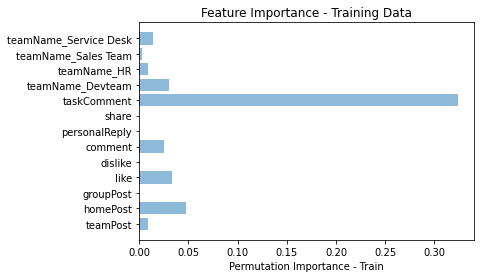

Permutation Importance for Test Data
{'teamPost': -0.0140625, 'homePost': -0.0046875, 'groupPost': 0.0, 'like': -0.003125, 'dislike': 0.0, 'comment': 0.0140625, 'personalReply': 0.0015625, 'share': -0.015625, 'taskComment': 0.271875, 'teamName_Devteam': -0.028125, 'teamName_HR': 0.0109375, 'teamName_Sales Team': -0.003125, 'teamName_Service Desk': -0.00625}


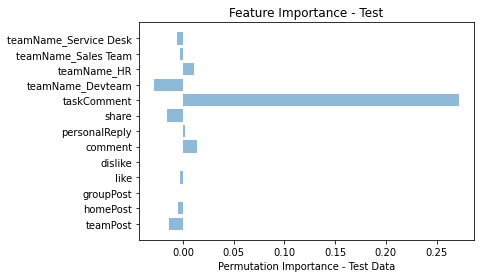

--------------------------------------------------------------------------
Probability of Performance Category: Bad
--------------------------------------------------------------------------
N: 255
Min: 0.00%
Max: 100.00%
Mean: 28.59%
--------------------------------------------------------------------------
Predicted Performance Category: Bad
Counter({0: 182, 1: 73})
N: 255
Min: 0.00%
Max: 100.00%
Mean: 28.63%


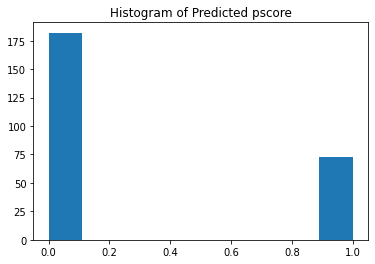

--------------------------------------------------------------------------
Scored Dataset
                       count        mean        std   min   25%    50%  \
index                  255.0  127.000000  73.756356   0.0  63.5  127.0   
userID                 255.0   46.031373  29.104735   2.0  15.0   63.0   
teamPost               255.0    1.364706   3.333841   0.0   0.0    0.0   
homePost               255.0    2.235294   6.665779   0.0   0.0    0.0   
groupPost              255.0    0.027451   0.438357   0.0   0.0    0.0   
like                   255.0    5.290196  12.033504   0.0   0.0    0.0   
dislike                255.0    0.043137   0.323158   0.0   0.0    0.0   
comment                255.0    1.505882   4.078820   0.0   0.0    0.0   
personalReply          255.0    0.074510   0.686152   0.0   0.0    0.0   
share                  255.0    0.070588   0.496957   0.0   0.0    0.0   
taskCreate             255.0    3.286275  12.509540   0.0   0.0    0.0   
taskAssign            

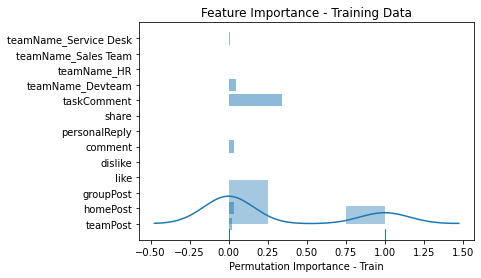

Permutation Importance for Test Data
{'teamPost': -0.0109375, 'homePost': 0.0265625, 'groupPost': 0.0, 'like': -0.021875, 'dislike': 0.0, 'comment': -0.0125, 'personalReply': 0.0, 'share': 0.0, 'taskComment': 0.275, 'teamName_Devteam': 0.0078125, 'teamName_HR': 0.0, 'teamName_Sales Team': 0.0, 'teamName_Service Desk': 0.0}


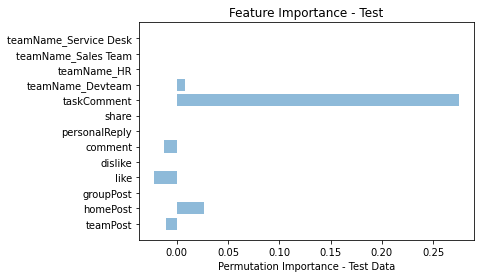

--------------------------------------------------------------------------
Probability of Performance Category: Bad
--------------------------------------------------------------------------
N: 255
Min: 0.09%
Max: 99.63%
Mean: 28.47%
--------------------------------------------------------------------------
Predicted Performance Category: Bad
Counter({0: 181, 1: 74})
N: 255
Min: 0.00%
Max: 100.00%
Mean: 29.02%


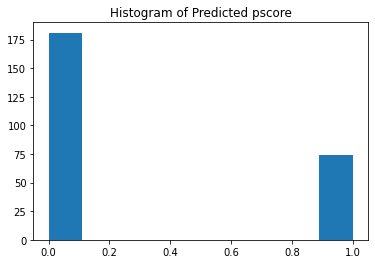

--------------------------------------------------------------------------
Scored Dataset
                       count        mean        std        min        25%  \
index                  255.0  127.000000  73.756356   0.000000  63.500000   
userID                 255.0   46.031373  29.104735   2.000000  15.000000   
teamPost               255.0    1.364706   3.333841   0.000000   0.000000   
homePost               255.0    2.235294   6.665779   0.000000   0.000000   
groupPost              255.0    0.027451   0.438357   0.000000   0.000000   
like                   255.0    5.290196  12.033504   0.000000   0.000000   
dislike                255.0    0.043137   0.323158   0.000000   0.000000   
comment                255.0    1.505882   4.078820   0.000000   0.000000   
personalReply          255.0    0.074510   0.686152   0.000000   0.000000   
share                  255.0    0.070588   0.496957   0.000000   0.000000   
taskCreate             255.0    3.286275  12.509540   0.000000 

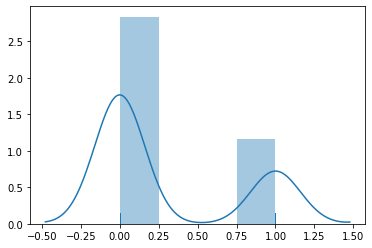

In [0]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance  # ,partial_dependence ,plot_partial_dependence
import collections 
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 0. select data for classification pipeline
#*** .loc with subset of colomns depreciated - use .reindex
#*** df example: df.reindex(['three', 'two', 'one'], axis='columns')
features = data_gb_rs_1h.reindex(['teamPost', 'homePost', 'groupPost', 'like', 'dislike', 'comment','personalReply', 'share', 'taskComment',
                                    'teamName_Devteam', 'teamName_HR', 'teamName_Sales Team', 'teamName_Service Desk'], 
                                    axis='columns')
target = data_gb_rs_1h.pcat_num.values
print('-'*74)
print('Features')
print(features.describe().T)
print('-'*74)
print('Target Class')
print(collections.Counter(target))

# create test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)
# create pipeline for transformations
numeric_features = ['teamPost', 'homePost', 'groupPost', 'like', 'dislike', 'comment', 'personalReply', 'share', 'taskComment']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                      ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)], remainder='passthrough')

# confusion matrix func
def plt_cm(model,cnames):
  # plot confusion matrix
  np.set_printoptions(precision=2)
  # Plot non-normalized confusion matrix
  classifier = model
  class_names = cnames
  titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
  for title, normalize in titles_options:
      disp = plot_confusion_matrix(classifier, X_test, y_test,
                                  display_labels=class_names,
                                  cmap=plt.cm.Blues,
                                  normalize=normalize)
      disp.ax_.set_title(title)
      print(title)
      print(disp.confusion_matrix)
  plt.show()


# model spot checking
clabels = ['Good', 'Bad']

# linear models
# logistic 
model1 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('logistic', LogisticRegression(solver='lbfgs', random_state=0))])
model1.fit(X_train, y_train)
print('-'*74)
print("logistic regression score: %f" % model1.score(X_test, y_test))
# plot confusion matrix
plt_cm(model1,clabels)

# ensemble models
# AdaBoost
n_trees = 100
model2 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('ada', AdaBoostClassifier(n_estimators=n_trees, random_state=0))])
model2.fit(X_train, y_train)
print('-'*74)
print("AdaBoostClassifier score: %f" % model2.score(X_test, y_test))
# plot confusion matrix
plt_cm(model2,clabels)

# Bagging
model3 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('bag', BaggingClassifier(n_estimators=n_trees, random_state=0))])
model3.fit(X_train, y_train)
print('-'*74)
print("BaggingClassifier score: %f" % model3.score(X_test, y_test))
# plot confusion matrix
plt_cm(model3,clabels)

# Random Forest
model4 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('rf', RandomForestClassifier(n_estimators=n_trees, random_state=0))])
model4.fit(X_train, y_train)
print('-'*74)
print("RandomForestClassifier score: %f" % model4.score(X_test, y_test))
# plot confusion matrix
plt_cm(model4,clabels)

# Extra Trees
model5 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('et', ExtraTreesClassifier(n_estimators=n_trees, random_state=0))])
model5.fit(X_train, y_train)
print('-'*74)
print("ExtraTreesClassifier score: %f" % model5.score(X_test, y_test))
# plot confusion matrix
plt_cm(model5,clabels)

# GBM
model6 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gb', GradientBoostingClassifier(n_estimators=n_trees, random_state=0))])
model6.fit(X_train, y_train)
print('-'*74)
print("GradientBoostingClassifier score: %f" % model6.score(X_test, y_test))
# plot confusion matrix
plt_cm(model6,clabels)

# create and save predicted scores
def pred_model_imp(model, mname):
  # create predict prob and predicted class
  gbc_prob = model.predict_proba(X_test)  #[:,1])
  gbc_pred = model.predict(X_test)
  # dict of predicted class and probability
  gbc_prob_pred = dict(zip(gbc_pred,gbc_prob))
  print('Test Data: Predicted Class and Class Probabilities')
  print(gbc_prob_pred)

  # feature names 
  feature_names = list(features.columns)
  # calculate permutation importance - train
  perm_imp_train = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
  # calculate permutation importance - test
  perm_imp_test = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
  # create dict of feature names and importances
  fimp_dict_train = dict(zip(feature_names,perm_imp_train.importances_mean))
  fimp_dict_test = dict(zip(feature_names,perm_imp_test.importances_mean))  
  
  # feature importance - train
  print('Permutation Importance for Train Data')
  print(fimp_dict_train)
  # plot importances - train
  y_pos = np.arange(len(feature_names))
  plt.barh(y_pos, perm_imp_train.importances_mean, align='center', alpha=0.5)
  plt.yticks(y_pos, feature_names)
  plt.xlabel('Permutation Importance - Train')
  plt.title('Feature Importance - Training Data')
  plt.show()

  # feature importance - test
  print('Permutation Importance for Test Data')
  print(fimp_dict_test)
  # plot importances - test
  y_pos = np.arange(len(feature_names))
  plt.barh(y_pos, perm_imp_test.importances_mean, align='center', alpha=0.5)
  plt.yticks(y_pos, feature_names)
  plt.xlabel('Permutation Importance - Test Data')
  plt.title('Feature Importance - Test')
  plt.show()

  # predict model score for all users

  # predict probability of performance category 'bad'
  pcat_bad_prob = model.predict_proba(features)[:,1]  #X_all)
  pcat_bad_pred = model.predict(features)

  # pscore descriptives
  print('-'*74)
  print('Probability of Performance Category: Bad')
  def dstats(ar):
    """Prints basic statistics from named tuple stats.describe() and formats them"""
    print(f'N: {stats.describe(ar).nobs:.0f}')
    print(f'Min: {stats.describe(ar).minmax[0]:.2%}')
    print(f'Max: {stats.describe(ar).minmax[1]:.2%}')
    print(f'Mean: {stats.describe(ar).mean:.2%}')

  print('-'*74)
  dstats(pcat_bad_prob) 

  print('-'*74)
  print('Predicted Performance Category: Bad')
  print(collections.Counter(pcat_bad_pred))
  dstats(pcat_bad_pred) 

  # plot histogram
  _ = plt.hist(pcat_bad_pred, bins='auto')
  plt.title('Histogram of Predicted pscore')
  plt.show()
  ax = sns.distplot(pcat_bad_pred, rug=True)

  # add predicted pscore, team and user names/ids to features 
  data_gb_rs_1h['prob_bad'] = pcat_bad_prob
  data_gb_rs_1h['pred_bad'] = pcat_bad_pred

  # describe and plot
  print('-'*74)
  print('Scored Dataset')
  print(data_gb_rs_1h.describe().T)

  # descriptives actual vs predicted
  actual_pred = data_gb_rs_1h[['pcat_num', 'pred_bad']]
  print('-'*74)
  print('Actual vs Predicted')
  print(actual_pred.describe().T)

  # write predicted pscore and features to csv
  filename = 'data_pred_pscore_ids_' + mname + '.csv'
  data_gb_rs_1h.to_csv(filename, index=False)


# hyperparameter tuning of best model
# GBM
model6 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gb', GradientBoostingClassifier(n_estimators=n_trees, random_state=0))])
model6.fit(X_train, y_train)
print('-'*74)
print("GradientBoostingClassifier score: %f" % model6.score(X_test, y_test))
# plot confusion matrix
plt_cm(model6,clabels)


# select best model and show feature importance + write scores to csv
# Random Forest Classifier
print('='*74)
print('Random Forest Classifier')
pred_model_imp(model4, 'rf')

# Gradient Boosting Classifier
print('='*74)
print('Gradient Boosting Classifier')
pred_model_imp(model6, 'gbm')




## **Hyper Parameter Tuning of Best Performing Models**

--------------------------------------------------------------------------
Features
                       count      mean        std  min  25%  50%  75%   max
teamPost               255.0  1.364706   3.333841  0.0  0.0  0.0  0.0  17.0
homePost               255.0  2.235294   6.665779  0.0  0.0  0.0  1.0  63.0
groupPost              255.0  0.027451   0.438357  0.0  0.0  0.0  0.0   7.0
like                   255.0  5.290196  12.033504  0.0  0.0  0.0  2.0  66.0
dislike                255.0  0.043137   0.323158  0.0  0.0  0.0  0.0   3.0
comment                255.0  1.505882   4.078820  0.0  0.0  0.0  1.0  33.0
personalReply          255.0  0.074510   0.686152  0.0  0.0  0.0  0.0  10.0
share                  255.0  0.070588   0.496957  0.0  0.0  0.0  0.0   5.0
taskComment            255.0  4.188235   8.232107  0.0  0.0  0.0  6.0  56.0
teamName_Devteam       255.0  0.282353   0.451029  0.0  0.0  0.0  1.0   1.0
teamName_HR            255.0  0.188235   0.391669  0.0  0.0  0.0  0.0   1.0
team

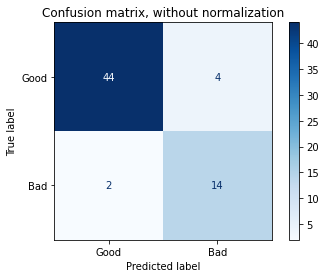

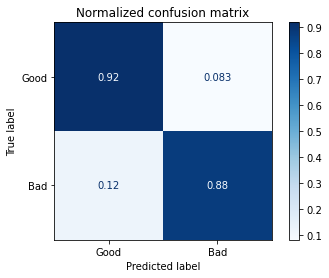

Tuned Gradient Boosting Classifier: Feature Importance
Test Data: Predicted Class and Class Probabilities
{1: array([0.09, 0.91]), 0: array([1.00e+00, 2.89e-05])}
Permutation Importance for Train Data
{'teamPost': 0.015183246073298485, 'homePost': 0.029319371727748754, 'groupPost': 0.0, 'like': 0.014659685863874394, 'dislike': 0.0, 'comment': 0.02513089005235606, 'personalReply': 0.0, 'share': 0.0, 'taskComment': 0.3340314136125655, 'teamName_Devteam': 0.05863874345549743, 'teamName_HR': 0.0, 'teamName_Sales Team': 0.007329842931937225, 'teamName_Service Desk': 0.005759162303664955}


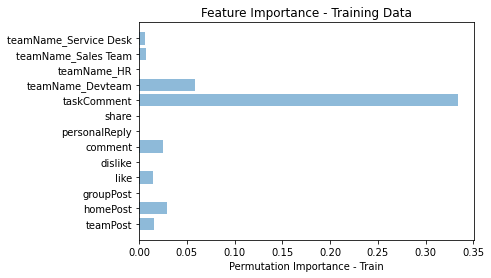

Permutation Importance for Test Data
{'teamPost': 0.01875, 'homePost': 0.009375, 'groupPost': 0.0, 'like': 0.0125, 'dislike': 0.0, 'comment': 0.015625, 'personalReply': 0.0, 'share': 0.0, 'taskComment': 0.2578125, 'teamName_Devteam': -0.0109375, 'teamName_HR': 0.0, 'teamName_Sales Team': -0.0015625, 'teamName_Service Desk': -0.00625}


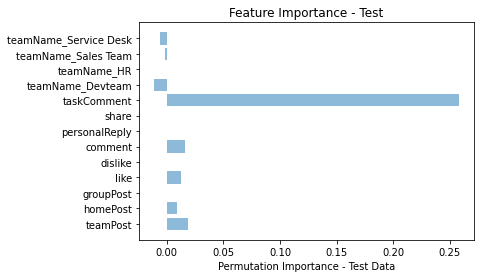

--------------------------------------------------------------------------
Probability of Performance Category: Bad
--------------------------------------------------------------------------
N: 255
Min: 0.00%
Max: 99.99%
Mean: 28.98%
--------------------------------------------------------------------------
Predicted Performance Category: Bad
Counter({0: 182, 1: 73})
N: 255
Min: 0.00%
Max: 100.00%
Mean: 28.63%


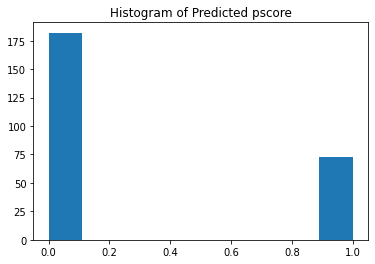

--------------------------------------------------------------------------
Scored Dataset
                       count        mean        std        min        25%  \
index                  255.0  127.000000  73.756356   0.000000  63.500000   
userID                 255.0   46.031373  29.104735   2.000000  15.000000   
teamPost               255.0    1.364706   3.333841   0.000000   0.000000   
homePost               255.0    2.235294   6.665779   0.000000   0.000000   
groupPost              255.0    0.027451   0.438357   0.000000   0.000000   
like                   255.0    5.290196  12.033504   0.000000   0.000000   
dislike                255.0    0.043137   0.323158   0.000000   0.000000   
comment                255.0    1.505882   4.078820   0.000000   0.000000   
personalReply          255.0    0.074510   0.686152   0.000000   0.000000   
share                  255.0    0.070588   0.496957   0.000000   0.000000   
taskCreate             255.0    3.286275  12.509540   0.000000 

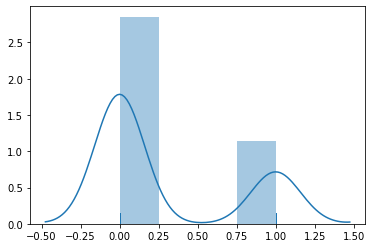

In [0]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance 
import collections 
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 0. select data for classification pipeline
#*** .loc with subset of colomns depreciated - use .reindex
#*** df example: df.reindex(['three', 'two', 'one'], axis='columns')
features = data_gb_rs_1h.reindex(['teamPost', 'homePost', 'groupPost', 'like', 'dislike', 'comment','personalReply', 'share', 'taskComment',
                                    'teamName_Devteam', 'teamName_HR', 'teamName_Sales Team', 'teamName_Service Desk'], 
                                    axis='columns')
target = data_gb_rs_1h.pcat_num.values
print('-'*74)
print('Features')
print(features.describe().T)
print('-'*74)
print('Target Class')
print(collections.Counter(target))

# create test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)
# create pipeline for transformations
numeric_features = ['teamPost', 'homePost', 'groupPost', 'like', 'dislike', 'comment', 'personalReply', 'share', 'taskComment']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                      ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)], remainder='passthrough')

# confusion matrix func
def plt_cm(model,cnames):
  # plot confusion matrix
  np.set_printoptions(precision=2)
  # Plot non-normalized confusion matrix
  classifier = model
  class_names = cnames
  titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
  for title, normalize in titles_options:
      disp = plot_confusion_matrix(classifier, X_test, y_test,
                                  display_labels=class_names,
                                  cmap=plt.cm.Blues,
                                  normalize=normalize)
      disp.ax_.set_title(title)
      print(title)
      print(disp.confusion_matrix)
  plt.show()


# hyperparameter tuning of best model

# GBM

# define models and parameters
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gb', GradientBoostingClassifier())]) 
params = {
    "gb__n_estimators": [10, 100, 1000],
    "gb__learning_rate" : [0.001, 0.01, 0.1],
    "gb__subsample" : [0.5, 0.7, 1.0],
    "gb__max_depth" : [3, 7, 9]
}
# define grid search
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# final model using best parameters
print('='*74)
print('Gradient Boosting Classifier: Best Parameters from Grid Search')
print(grid_result.best_params_)
# set best parameters to use in final model
model.set_params(**grid_result.best_params_)
model.fit(X_train, y_train)
print("Tuned GradientBoostingClassifier score: %f" % model.score(X_test, y_test))
# plot confusion matrix
plt_cm(model,clabels)
# show feature importance for best model + write scores to csv
# Gradient Boosting Classifier
print('='*74)
print('Tuned Gradient Boosting Classifier: Feature Importance')
pred_model_imp(model, 'gbm')



Gradient Boosting Classifier: Best Parameters from Grid Search
{'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__n_estimators': 100, 'gb__subsample': 0.7}
Tuned GradientBoostingClassifier score: 0.875000
Confusion matrix, without normalization
[[43  5]
 [ 3 13]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.19 0.81]]


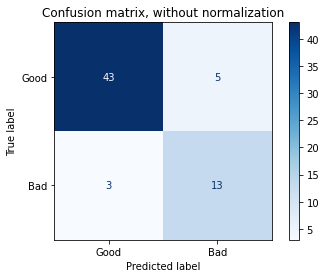

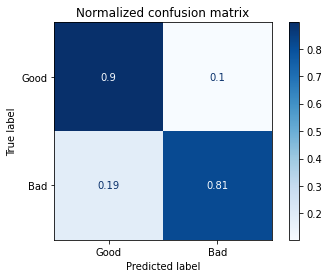

In [0]:
# final model using best parameters
print('='*74)
print('Gradient Boosting Classifier: Best Parameters from Grid Search')
print(grid_result.best_params_)
# set best parameters to use in final model
model.set_params(**grid_result.best_params_)
model.fit(X_train, y_train)
print("Tuned GradientBoostingClassifier score: %f" % model.score(X_test, y_test))
# plot confusion matrix
plt_cm(model,clabels)

In [0]:
# check names of attributes in pipeline
#model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'gb', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'gb__ccp_alpha', 'gb__criterion', 'gb__init', 'gb__learning_rate', 'gb__loss', 'gb__max_depth', 'gb__max_features', 'gb__max_leaf_nodes', 'gb__min_impurity_decrease', 'gb__min_impurity_split', 'gb__min_samples_leaf', 'gb__min_sampl

# **TO DO's**

## **Try models for Imbalanced Classification**

## **XGBoost binary classification spot check**

In [0]:
# 3. XGBoost binary classification spot check script

# load libraries
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import plot_partial_dependence
from xgboost import XGBClassifier
 
# load the dataset, returns X and y elements
def load_dataset():
	return make_classification(n_samples=1000, n_classes=2, random_state=1)
 
# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models
 
# define gradient boosting models
def define_gbm_models(models=dict(), use_xgb=True):
	# define config ranges
	rates = [0.001, 0.01, 0.1]
	trees = [50, 100]
	ss = [0.5, 0.7, 1.0]
	depth = [3, 7, 9]
	# add configurations
	for l in rates:
		for e in trees:
			for s in ss:
				for d in depth:
					cfg = [l, e, s, d]
					if use_xgb:
						name = 'xgb-' + str(cfg)
						models[name] = XGBClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
					else:
						name = 'gbm-' + str(cfg)
						models[name] = GradientBoostingClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
	print('Defined %d models' % len(models))
	return models
 
# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
	return scores
 
# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, metric)
	except:
		scores = None
	return scores
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='accuracy'):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		scores = robust_evaluate_model(X, y, model, folds, metric)
		# show process
		if scores is not None:
			# store a result
			results[name] = scores
			mean_score, std_score = mean(scores), std(scores)
			print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
		else:
			print('>%s: error' % name)
	return results
 
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')
 
# load dataset
X, y = dataframe.iloc[:,:-1], dataframe.iloc[:,-1]  # X, y = load_dataset()
# get model list
models = define_models()
# add gbm models
models = define_gbm_models(models)
# evaluate models
results = evaluate_models(X, y, models)
# summarize results
summarize_results(results)

## **Dashboard**